# おまけ

In [2]:
import numpy as np
from matplotlib import pyplot as plt


## 非圧縮性Navie-Stokes方程式

有名なニュートン流体の運動方程式．2次元行列表示すると，

$$
    \partial_t
    \left( \begin{array}{c} v_x \\ v_y \\ \end{array} \right)
    = -\lambda_1
    \left(
    \begin{array}{cc}
        \partial_x v_x & \partial_y v_x \\ 
        \partial_x v_y & \partial_y v_y
    \end{array}
    \right)
    \left(
    \begin{array}{c}
        v_x \\ v_y 
    \end{array}
    \right)
    -
    \left(
    \begin{array}{c}
        \partial_x p \\ \partial_y p  
    \end{array}
    \right)
    +\lambda_2 (\partial_{xx}+\partial_{yy})
    \left(
    \begin{array}{c}
        v_x \\  v_y  
    \end{array}
    \right)
$$
です．　ここで，連続の式を満たすように圧力を補正する必要があります．
ここでは，キャビティー流れを考えます．ただしコード中の圧力境界の取り扱いは正しくありません．
本来はポアソン式を解く数値計算スキームの中で修正し続ける必要があります．


0.020824656393169508


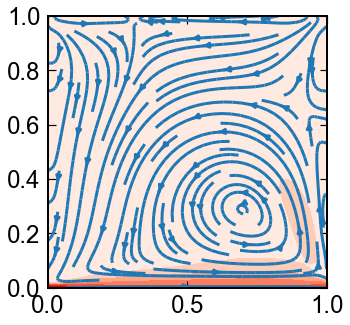

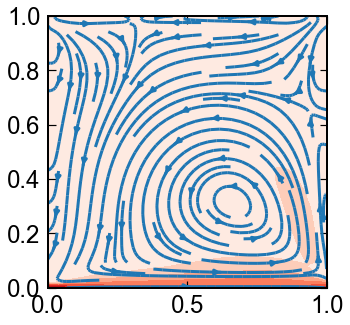

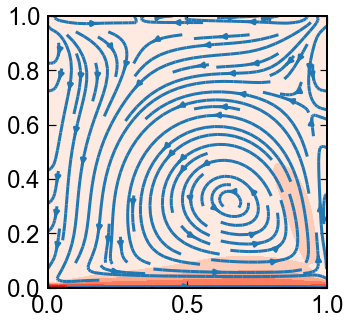

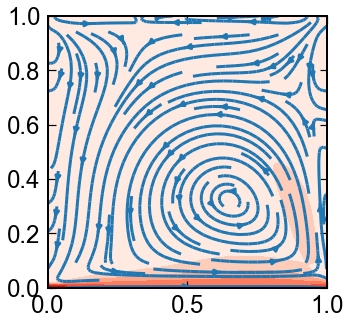

In [3]:
# parameter
N = Nx = Ny = 50
Δ = Δx = Δy = 1.0/(N-1)
Re = 500.0
Δt = 0.1*Δ**2*Re
print(Δt)

# init
vx = np.zeros((N+3,N+2),dtype='f8')
vy = np.zeros((N+2,N+3),dtype='f8')
p  = np.zeros((N+2,N+2),dtype='f8')

C = +np.diag(np.ones((N+2)**2-1  )* 1.0,k=+1  )\
    +np.diag(np.ones((N+2)**2    )*-4.0,k= 0  )\
    +np.diag(np.ones((N+2)**2-1  )* 1.0,k=-1  )\
    +np.diag(np.ones((N+2)**2-N-2)* 1.0,k=+N+2)\
    +np.diag(np.ones((N+2)**2-N-2)* 1.0,k=-N-2)
C /= Δ**2
C = csr_matrix(C)

X,Y = 0,1
def cent(v,axis):
    if   axis==X: return 0.5*(v[1:,:]+v[:-1,:])
    elif axis==Y: return 0.5*(v[:,1:]+v[:,:-1])
    else: return v
def diff1(v,axis):
    if   axis==X: return (v[1:,:]-v[:-1,:])/Δ
    elif axis==Y: return (v[:,1:]-v[:,:-1])/Δ
    else: return v        
def diff2(v):
    return ((v[2:]-2*v[1:-1]+v[:-2])[:,1:-1] + (v[:,2:]-2*v[:,1:-1]+v[:,:-2])[1:-1,:])/Δ**2

def ODEs(loop,vx,vy,p):
    # init
    vxn,vyn = np.zeros((N+3,N+2)),np.zeros((N+2,N+3),dtype='f8')
    dvx,dvy = np.zeros((N+3,N+2)),np.zeros((N+2,N+3),dtype='f8')
    for i in range(loop):
        # BC
        vx[0 ,:] = vy[1,: ] =0.0  # left
        vx[-1,:] = vy[-2,:] =0.0  # right
        vx[:,0 ] = 2.0 - vx[:,1 ] # upper
        vx[:,-1] = 0.0 - vx[:,-2] # lower
        #
        vy[0 ,:] = 0.0 - vy[1,: ] # left
        vy[-1,:] = 0.0 - vy[-2,:] # right
        vy[:,0 ] = vy[:,1 ] =0.0  # upper
        vy[:,-1] = vy[:,-2] =0.0  # lower
        #
        p[1 ,:] = p[0 ,:] # left
        p[-2,:] = p[-1,:] # right
        p[:,-2] = p[:,-1] # lower        
        #
        dvx[:] = 0.0
        dvy[:] = 0.0
        # advection term
        dvx[1:-1,:   ] -= cent(diff1(vx,X),X)*vx[1:-1,:]
        dvx[1:-1,1:-1] -= cent(diff1(vx,Y),Y)[1:-1,:]*cent(cent(vy,X),Y)[:,1:-1]
        dvy[1:-1,1:-1] -= cent(diff1(vy,X),X)[:,1:-1]*cent(cent(vx,X),Y)[1:-1,:]
        dvy[:   ,1:-1] -= cent(diff1(vy,Y),Y)*vy[:,1:-1]
        # pressure gradient term
        dvx[1:-1,:] -= diff1(p,X)
        dvy[:,1:-1] -= diff1(p,Y)
        # diffusion term
        dvx[1:-1,1:-1] += (1./Re)*diff2(vx)
        dvy[1:-1,1:-1] += (1./Re)*diff2(vy)        
        # dev velocity
        vxn = vx + Δt*dvx
        vyn = vy + Δt*dvy
        # dev pressure
        δp = spsolve(C, (diff1(vxn,X)+diff1(vyn,Y)).flatten()/Δt )
        δp = δp.reshape(N+2,N+2)
        # modify terms
        vxn[1:-1,:] -= Δt* diff1(δp,X)
        vyn[:,1:-1] -= Δt* diff1(δp,Y)
        p += δp
        vx,vxn = vxn,vx
        vy,vyn = vyn,vy
    return vx,vy,p

x = np.linspace(0.,1.,N+2)
xx,yy = np.meshgrid(x,x)

max_step=2000
frame=4
for i in range(frame):
    fig,ax = plt.subplots(figsize=(5,5))
    vx,vy,p = ODEs(max_step//frame,vx,vy,p)
    plt.xlim(0.0,1.0)
    plt.ylim(0.0,1.0)    
    plt.contourf(xx,yy,np.sqrt(cent(vx,X)**2+cent(vy,Y)**2).T,cmap='Reds')
    plt.streamplot(xx,yy,cent(vx,X).T,cent(vy,Y).T)
    plt.show()

    